In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [ ]:
# Define domain
c = 1.0  # Reference length of triangle

xmin, xmax = 0.0, 2.0 * c
ymin, ymax = 0.0, 0.85 * c

# Definition of three points
v1 = jnp.array([0.0, 0.0])
v2 = jnp.array([2.0 * c, 0.0])
v3 = jnp.array([c, 0.85 * c])

vertices = jnp.stack([v1, v2, v3])

# Number of sampling points
N_dbc = 200  # Dirichlet BC
N_nfbc = 400 # No-Flow BC
N_pde = 1000 # Internal collocation points (PDE)

In [ ]:
def create_training_data_triangle(key, N_dbc, N_pde, N_nfbc, c, vertices):
    """
    Generates training points for the triangular domain and configures them
    according to boundary conditions.

    - DBC (Dirichlet): Base (v1 -> v2)
    - NFBC (No-Flow): Two hypotenuses (v2 -> v3, v3 -> v1)
    - PDE: Interior

    Returns:
    - colloc_points (N_pde, 2): PDE residual points
    - bc_conds (list): Dirichlet BC data. [ (N_dbc, 3) ]
    - nfbc_data (dict): No-Flow BC data
    """
    key_dbc, key_pde, key_nfbc = jax.random.split(key, 3)

    # --- 1. Dirichlet BC Points (Base, N_dbc) ---
    # Segment 0: v1 -> v2
    key_dbc_t, = jax.random.split(key_dbc, 1)

    t_dbc = jax.random.uniform(key_dbc_t, shape=(N_dbc, 1))

    # Sample only between v1 and v2
    v_start_dbc = vertices[0]
    v_end_dbc = vertices[1]

    dbc_points = (1 - t_dbc) * v_start_dbc + t_dbc * v_end_dbc

    # [Unified] Assign BC value (h=0.0)
    h_dbc_all = jnp.zeros((N_dbc, 1))
    dbc_all = jnp.concatenate([dbc_points, h_dbc_all], axis=1)
    bc_conds = [dbc_all] # Wrapped in a list as loss_fun iterates over it

    # --- 2. PDE Collocation Points (Interior, N_pde) ---
    # (Same Rejection Sampling logic as in the previous step)
    key_pde_x, key_pde_y = jax.random.split(key_pde, 2)

    x_min, x_max = 0.0, 2.0 * c
    y_min, y_max = 0.0, c

    # Sampling efficiency 50% (Triangle area c^2 / Box area 2c^2)
    n_samples_large = int(N_pde * 2.5) # Generous 2.5x sampling

    x_c_all = jax.random.uniform(key_pde_x, minval=x_min, maxval=x_max, shape=(n_samples_large, 1))
    y_c_all = jax.random.uniform(key_pde_y, minval=y_min, maxval=y_max, shape=(n_samples_large, 1))

    # "Interior" check mask (based on 3 outer boundary lines)
    v_start_all = vertices
    v_end_all = jnp.roll(vertices, -1, axis=0)

    A_outer = v_start_all[:, 1] - v_end_all[:, 1]
    B_outer = v_end_all[:, 0] - v_start_all[:, 0]
    C_outer = v_start_all[:, 0] * v_end_all[:, 1] - v_end_all[:, 0] * v_start_all[:, 1]

    cx = jnp.mean(vertices[:, 0])
    cy = jnp.mean(vertices[:, 1])

    centroid_signs = cx * A_outer + cy * B_outer + C_outer
    line_eqs = x_c_all * A_outer + y_c_all * B_outer + C_outer
    mask = jnp.all((line_eqs * centroid_signs) >= 0.0, axis=1)
    mask_flat = mask.flatten()

    # Sample N_pde points using Numpy
    x_c_np = np.array(x_c_all[mask_flat])
    y_c_np = np.array(y_c_all[mask_flat])

    if len(x_c_np) >= N_pde:
        x_c = jnp.array(x_c_np[:N_pde]).reshape(-1, 1)
        y_c = jnp.array(y_c_np[:N_pde]).reshape(-1, 1)
    else:
        print(f"Warning: Only {len(x_c_np)} points sampled. Need {N_pde}.")
        x_c = jnp.array(x_c_np).reshape(-1, 1)
        y_c = jnp.array(y_c_np).reshape(-1, 1)

    colloc_points = jnp.concatenate([x_c, y_c], axis=1)

    # --- 3. [Modified] No-Flow BC Points (Two hypotenuses, N_nfbc) ---
    # Segment 1: v2 -> v3
    # Segment 2: v3 -> v1

    key_nfbc_t, key_nfbc_i = jax.random.split(key_nfbc, 2)

    # Vertices for NFBC
    v_start_nfbc = jnp.stack([vertices[1], vertices[2]]) # [v2, v3]
    v_end_nfbc = jnp.stack([vertices[2], vertices[0]]) # [v3, v1]

    # Calculate lengths of two hypotenuses (both are sqrt(2)c)
    lengths_nfbc = jnp.linalg.norm(v_end_nfbc - v_start_nfbc, axis=1)
    probs_nfbc = lengths_nfbc / jnp.sum(lengths_nfbc)

    # Select N_nfbc edge indices based on probabilities (a=2)
    # segment_indices takes values [0, 1] (0: v2->v3, 1: v3->v1)
    segment_indices = jax.random.choice(key_nfbc_i, a=jnp.arange(2), shape=(N_nfbc,), p=probs_nfbc)

    # Uniformly sample N_nfbc interpolation coefficients (t) between 0 and 1
    t_nfbc = jax.random.uniform(key_nfbc_t, shape=(N_nfbc, 1))

    # Generate points
    nfbc_points = (1 - t_nfbc) * v_start_nfbc[segment_indices] + t_nfbc * v_end_nfbc[segment_indices]

    # Calculate Normal Vector components (A, B) for No-Flow Line
    # A = y1 - y2, B = x2 - x1
    A_lines = v_start_nfbc[:, 1] - v_end_nfbc[:, 1] # (2,)
    B_lines = v_end_nfbc[:, 0] - v_start_nfbc[:, 0] # (2,)

    nfbc_data = {
        'points': nfbc_points,      # (N_nfbc, 2)
        'indices': segment_indices, # (N_nfbc,) - Indices for A_lines, B_lines
        'A_lines': A_lines,         # (2,)
        'B_lines': B_lines          # (2,)
    }

    return colloc_points, bc_conds, nfbc_data

# --- 4. Execute Point Generation ---
key = jax.random.PRNGKey(42)
colloc_points, bc_conds, nfbc_data = create_training_data_triangle(
    key, N_dbc, N_pde, N_nfbc, c, vertices
)

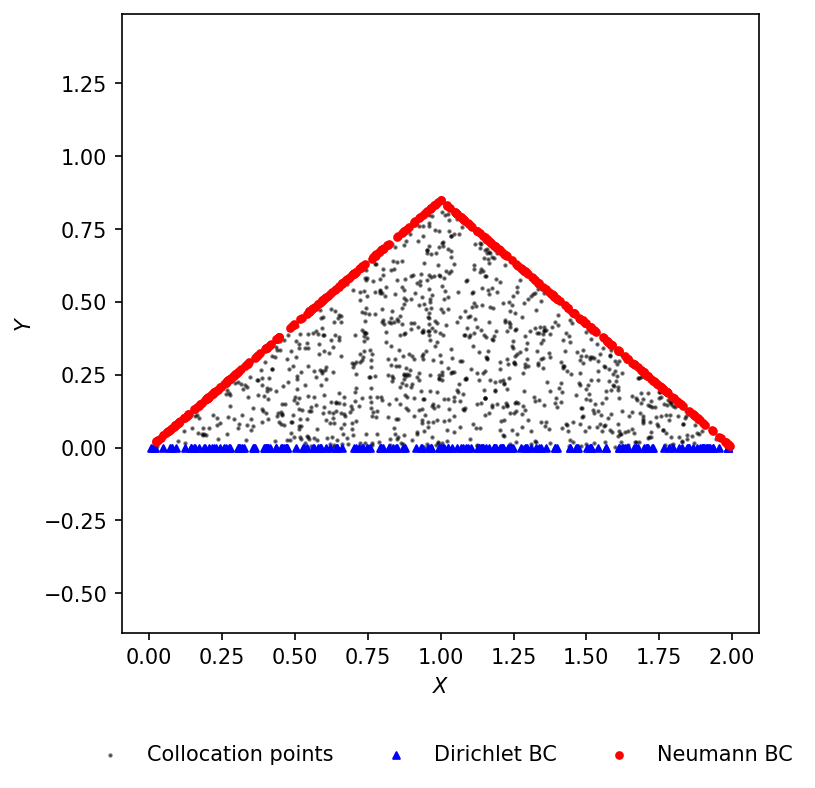

In [ ]:
def plot_sampling_triangle_detailed(colloc_points, bc_conds, nfbc_data, vertices):
    cc_np = np.array(colloc_points)
    dbc_np = np.array(bc_conds[0][:, :2])
    nfbc_np = np.array(nfbc_data['points'])
    v_np = np.array(vertices)
    plt.figure(figsize=(5, 5.5), dpi=150)


    s_colloc = 5
    plt.scatter(cc_np[:, 0], cc_np[:, 1], c='k', marker='.', alpha=0.5,
                s=s_colloc, label='Collocation points')

    s_bc = 10
    plt.scatter(dbc_np[:, 0], dbc_np[:, 1], c='blue', marker='^', s=s_bc,
                label=f'Dirichlet BC')

    plt.scatter(nfbc_np[:, 0], nfbc_np[:, 1], c='red', marker='o', s=s_bc,
                label=f'Neumann BC')

    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.xlim(-0.05, 2.05)
    plt.ylim(-0.05, 0.9)
    plt.axis('equal')
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95)

    plt.show()

# Visualization
plot_sampling_triangle_detailed(colloc_points, bc_conds, nfbc_data, vertices)

In [ ]:
def hydraulic_conductivity(x, y):
  T_x = jnp.ones_like(x)*1.5
  T_y = jnp.ones_like(y)*1.5
  return T_x, T_y

In [ ]:
def pde_residual_2d_darcy(x,y,h):
    """
    Compute the PDE residual for the 2D Laplace equation.

    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    h: Lambda function representing the neural network solution h(x, y).

    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x, T_y = hydraulic_conductivity(x, y)

    h_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),0)(x,y)
    h_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(h_x(x,y)),0)(x,y)

    h_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),1)(x,y)
    h_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(h_y(x,y)),1)(x,y)

    # return T_x*h_xx(x,y) + T_y*h_yy(x,y)
    return T_x*h_xx(x,y) + T_y*h_yy(x,y) + 1e-5/(1e-4)**2

Define Neural Network Architecture

In [ ]:
# Define Neural Network Architecture
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict h(x, y).

    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).

    Output:
    Predicted h(x, y) values (N x 1).
    """
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.

    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).

    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters

    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list

    return params  # Return the initialized parameters

Define Loss Function

In [ ]:
@jax.jit
def loss_fun(params, colloc, conds):

    h_nn = lambda x, y: neural_net(params, x, y)

    # PDE residual
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]
    pde_res_c = pde_residual_2d_darcy(x_c, y_c, h_nn)
    pde_loss = jnp.mean(pde_res_c**2)

    # Dirichlet BC loss
    dbc_loss = 0.0
    for cond in conds[0:2]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        dbc_loss += jnp.mean((h_nn(x_b, y_b) - u_b)**2)

    # Neumann (No-Flow) BC loss
    x_nfbc, y_nfbc = nfbc_data['points'][:, [0]], nfbc_data['points'][:, [1]]

    h_x_nfbc = lambda x, y: jax.grad(lambda x, y: jnp.sum(h_nn(x, y)), 0)(x, y)
    h_y_nfbc = lambda x, y: jax.grad(lambda x, y: jnp.sum(h_nn(x, y)), 1)(x, y)
    grad_h_x = h_x_nfbc(x_nfbc, y_nfbc) # (N_i, 1)
    grad_h_y = h_y_nfbc(x_nfbc, y_nfbc) # (N_i, 1)

    indices = nfbc_data['indices'] # (N_i,)
    A_lines = nfbc_data['A_lines'] # (6,)
    B_lines = nfbc_data['B_lines'] # (6,)

    A_i = A_lines[indices].reshape(-1, 1) # (N_i, 1)
    B_i = B_lines[indices].reshape(-1, 1) # (N_i, 1)

    # 3.3. No-flow residual calculation : R = ∇h⋅∇f = A*h_x + B*h_y
    residual_nfbc = grad_h_x * A_i + grad_h_y * B_i
    nbc_loss = jnp.mean(residual_nfbc**2)


    loss = 1 * pde_loss + 100 * dbc_loss + 20 * nbc_loss

    return loss

In [ ]:
# ---  PINN prediction and plotting results ---
nx = 101
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 101
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)
X_flat = X.flatten().reshape(-1, 1)
Y_flat = Y.flatten().reshape(-1, 1)

In [ ]:
# Define hyperparameters for the neural network and training
hidden_nodes = 30      # Number of nodes in each hidden layer
hidden_layers = 3      # Number of hidden layers in the neural network
initial_learning_rate = 5e-3
lr_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=5000,
    decay_rate=0.8
)
epochs = 50000

# Construct the MLP (Multilayer Perceptron) using the specified architecture
key, pkey = jax.random.split(key, 2) # New key for parameter initialization
params = init_params([2] + [hidden_nodes] * hidden_layers + [1])

# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = optax.adam(learning_rate = lr_schedule)
opt_state = optimizer.init(params)

# *** Parameters update function ***
@jax.jit
def update(opt_state, params, colloc, conds):
    grads = jax.grad(loss_fun, 0)(params, colloc, conds)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

# ---  PINN training loop  ---
print('PINN training started...')

best_params = params
best_loss = float('inf')
best_epoch = 0
all_losses = []
all_epochs = []

for epoch in range(epochs+1):
    opt_state, params = update(opt_state, params, colloc_points, bc_conds)

    if epoch % 100 == 0:
        current_loss = loss_fun(params, colloc_points, bc_conds)

        all_losses.append(current_loss)
        all_epochs.append(epoch)

        if current_loss < best_loss:
            best_loss = current_loss
            best_params = params
            best_epoch = epoch

        print(f'Epoch={epoch}\tloss={current_loss:.3e}')


print('PINN training done!')
print(f'Best Epoch = {best_epoch}\tBest Loss = {best_loss:.3e}')

PINN training started...
Epoch=0	loss=9.997e+05
Epoch=100	loss=4.536e+05
Epoch=200	loss=3.052e+05
Epoch=300	loss=2.142e+05
Epoch=400	loss=1.774e+05
Epoch=500	loss=1.480e+05
Epoch=600	loss=1.291e+05
Epoch=700	loss=1.134e+05
Epoch=800	loss=1.013e+05
Epoch=900	loss=9.233e+04
Epoch=1000	loss=8.450e+04
Epoch=1100	loss=6.997e+04
Epoch=1200	loss=6.200e+04
Epoch=1300	loss=5.712e+04
Epoch=1400	loss=9.174e+04
Epoch=1500	loss=4.750e+04
Epoch=1600	loss=4.542e+04
Epoch=1700	loss=4.092e+04
Epoch=1800	loss=3.876e+04
Epoch=1900	loss=3.554e+04
Epoch=2000	loss=3.219e+04
Epoch=2100	loss=3.089e+04
Epoch=2200	loss=3.448e+04
Epoch=2300	loss=2.621e+04
Epoch=2400	loss=2.435e+04
Epoch=2500	loss=2.178e+04
Epoch=2600	loss=2.364e+04
Epoch=2700	loss=1.891e+04
Epoch=2800	loss=1.947e+04
Epoch=2900	loss=1.595e+04
Epoch=3000	loss=1.781e+04
Epoch=3100	loss=1.443e+04
Epoch=3200	loss=1.424e+04
Epoch=3300	loss=1.251e+04
Epoch=3400	loss=1.271e+04
Epoch=3500	loss=1.127e+04
Epoch=3600	loss=1.107e+04
Epoch=3700	loss=3.484e+04

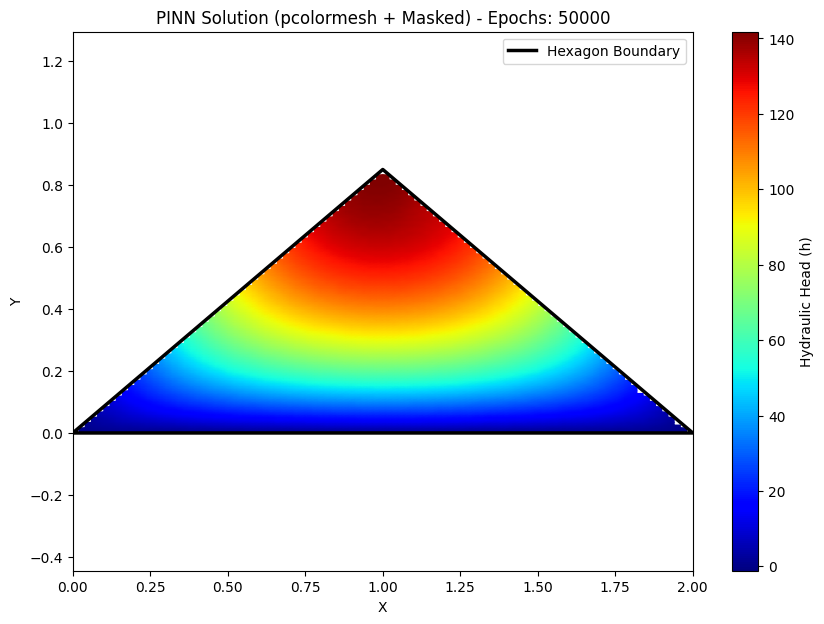

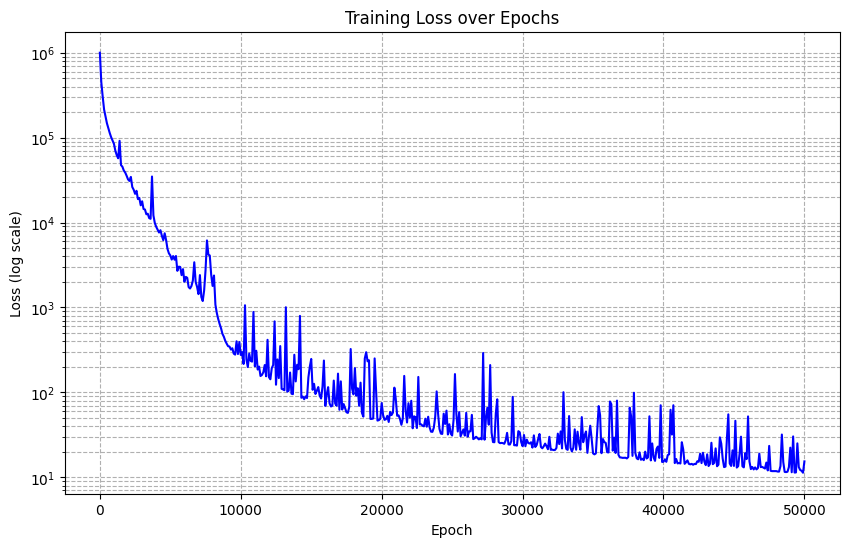

In [ ]:
# --- Result VIsualization ---

pinn_h_flat = neural_net(best_params, X_flat, Y_flat)

v_start = vertices
v_end = jnp.roll(vertices, -1, axis=0)
A = v_start[:, 1] - v_end[:, 1]
B = v_end[:, 0] - v_start[:, 0]
C = v_start[:, 0] * v_end[:, 1] - v_end[:, 0] * v_start[:, 1]
cx = jnp.mean(vertices[:, 0])
cy = jnp.mean(vertices[:, 1])
centroid_signs = cx * A + cy * B + C

line_eqs = X_flat * A + Y_flat * B + C
mask = jnp.all((line_eqs * centroid_signs) >= 0.0, axis=1)

pinn_h_flat_masked = jnp.where(mask.reshape(-1, 1), pinn_h_flat, jnp.nan)

pinn_h = pinn_h_flat_masked.reshape(nx, ny)
pinn_h_np = np.array(pinn_h)

fig, ax = plt.subplots(figsize=(10, 7))
cf = ax.pcolormesh(X, Y, pinn_h_np, shading='gouraud', cmap=cm.jet,
                   vmin=np.nanmin(pinn_h_np), vmax=np.nanmax(pinn_h_np))
plt.colorbar(cf, label='Hydraulic Head (h)')

v_np = np.array(vertices)
hexagon_plot = np.concatenate([v_np, v_np[0:1]], axis=0)
ax.plot(hexagon_plot[:, 0], hexagon_plot[:, 1],
         'k-', lw=2.5, label='Hexagon Boundary')

ax.set_title(f'PINN Solution (pcolormesh + Masked) - Epochs: {epochs}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.axis('equal')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

# Loss function graph
plt.figure(figsize=(10, 6))
plt.plot(all_epochs, all_losses, 'b-')
plt.yscale('log')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()

Detected Grid: 41x17
Physical Domain: 20000.0 x 8500.0 m

--- Random Sampling (30%) ---
Total Valid Cells: 325
Selected Points: 97
RMSE (sampled 30%): 4.9745 m


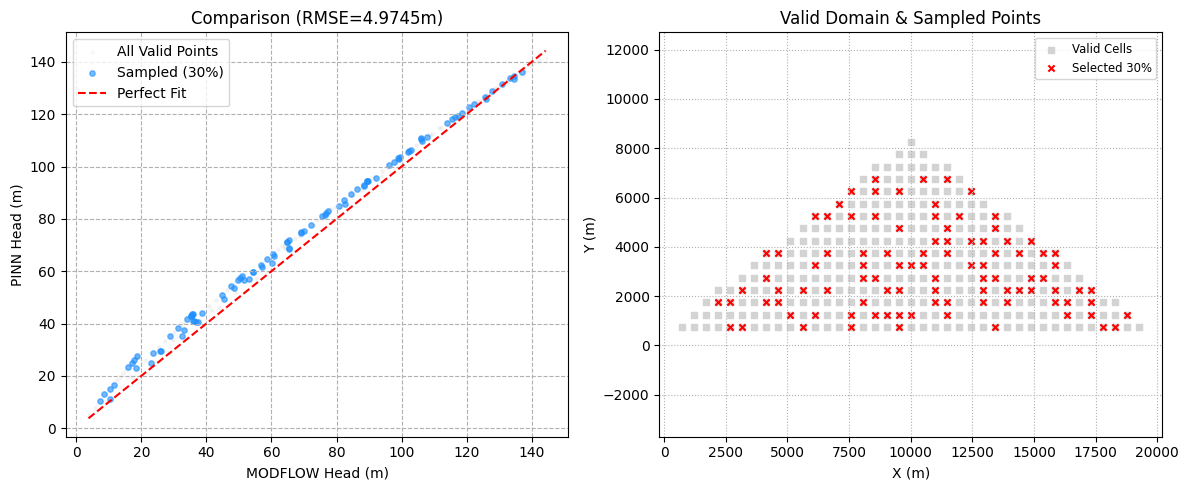

In [ ]:
# 30% random sampling and RMSE calculation

base_path = os.getcwd()
data_folder = os.path.join(base_path, 'data')
file_name = 'Case6.txt'
file_path = os.path.join(data_folder, file_name)

# 1. Check file existence and load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Can not find data file: {file_path}")

try:
    # 2. Load data
    df = pd.read_csv(file_name, skipinitialspace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    # 3. Filtering Active Cell and delete h = 0
    if 'Active' in df.columns:
        df_temp = df[df['Active'] == 1].copy()
    else:
        df_temp = df[(df['f'] > -1000) & (df['f'] < 10000)].copy()

    df_active = df_temp[np.abs(df_temp['f']) > 1e-5].copy()

    # 4. Grid information and physical size configuration (estimated based on filename)
    Nx_mf = df['j'].max() # 41
    Ny_mf = df['i'].max() # 17

    # [Important] Actual physical size of the triangular domain (20000 x 8500)
    # If c=10000 in PINN code, then 2c = 20000, 0.85c = 8500
    L_x_phys = 20000.0
    L_y_phys = 8500.0

    dx_phys = L_x_phys / Nx_mf
    dy_phys = L_y_phys / Ny_mf

    print(f"Detected Grid: {Nx_mf}x{Ny_mf}")
    print(f"Physical Domain: {L_x_phys} x {L_y_phys} m")

    # 5. Coordinate Transformation
    # (1) Physical coordinates
    df_active['x_phys'] = (df_active['j'] - 0.5) * dx_phys
    # MODFLOW i=1 starts at Top (8500) and descends
    df_active['y_phys'] = L_y_phys - (df_active['i'] - 0.5) * dy_phys

    # (2) Normalized coordinates (for PINN input)
    # Based on c=1.0 during PINN training: xmax=2.0, ymax=0.85
    # Therefore, divide by 10000 (when c=10000)
    scale_factor = 10000.0

    df_active['x_norm'] = df_active['x_phys'] / scale_factor
    df_active['y_norm'] = df_active['y_phys'] / scale_factor

    # 6. PINN Prediction
    x_in = df_active['x_norm'].values.reshape(-1, 1)
    y_in = df_active['y_norm'].values.reshape(-1, 1)
    x_jax = jnp.array(x_in)
    y_jax = jnp.array(y_in)

    if 'best_params' not in locals():
        raise NameError("best_params is undefined. Train the model first.")

    h_pinn_all = neural_net(best_params, x_jax, y_jax)
    h_mf_all = df_active['f'].values.reshape(-1, 1)

    # =========================================================
    # [Random Sampling] Extract 30% and calculate RMSE
    # =========================================================
    N_total = len(h_mf_all)
    n_samples = int(N_total * 0.30)

    print(f"\n--- Random Sampling (30%) ---")
    print(f"Total Valid Cells: {N_total}")
    print(f"Selected Points: {n_samples}")

    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(N_total, size=n_samples, replace=False)

    h_pinn_sampled = h_pinn_all[random_indices]
    h_mf_sampled = h_mf_all[random_indices]

    diff = h_pinn_sampled - h_mf_sampled
    rmse = np.sqrt(np.mean(diff**2))

    print(f"RMSE (sampled 30%): {rmse:.4f} m")

    # --- 7. Visualization ---
    plt.figure(figsize=(12, 5))

    # (1) Parity Plot
    plt.subplot(1, 2, 1)
    plt.scatter(h_mf_all, h_pinn_all, alpha=0.1, s=5, c='lightgray', label='All Valid Points')
    plt.scatter(h_mf_sampled, h_pinn_sampled, alpha=0.6, s=15, c='dodgerblue', label='Sampled (30%)')

    min_val = min(h_mf_all.min(), h_pinn_all.min())
    max_val = max(h_mf_all.max(), h_pinn_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

    plt.xlabel("MODFLOW Head (m)")
    plt.ylabel("PINN Head (m)")
    plt.title(f"Comparison (RMSE={rmse:.4f}m)")
    plt.legend()
    plt.grid(True, linestyle='--')

    # (2) Domain Check (Verify Triangle)
    plt.subplot(1, 2, 2)

    x_all = df_active['x_phys'].values
    y_all = df_active['y_phys'].values
    x_sampled = x_all[random_indices]
    y_sampled = y_all[random_indices]

    # All valid area (should be triangular)
    plt.scatter(x_all, y_all, s=15, c='lightgray', marker='s', label='Valid Cells')
    # Sampled points
    plt.scatter(x_sampled, y_sampled, s=20, c='r', marker='x', label='Selected 30%')

    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Valid Domain & Sampled Points")
    plt.legend(loc='upper right', fontsize='small')
    plt.axis('equal')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    print("Please check the data file format or ensure 'best_params' has been trained.")

In [ ]:
# 1. Maximum PINN prediction
max_pinn = np.max(h_pinn_all)
print(f"PINN Predicted Max Head: {max_pinn:.4f} m")

# 2. (For comparison) Maximum MODFLOW actual head
max_mf = np.max(h_mf_all)
print(f"MODFLOW Actual Max Head: {max_mf:.4f} m")

PINN 예측 최대 수두 (Max Head): 141.6539 m
MODFLOW 실제 최대 수두 (Max Head): 144.2632 m


TypeError: Cannot index by location index with a non-integer key